# Вступление

Этот проект показывает: 
- способность писать структурированный код на Python. 
- возможность использования существующих утилит(библиотек) для обработки и анализа данных.
- навыки анализа и предварительной обработки данных
- визуализация данных
- проработка бизнес задачи и бизнес метрик
- использование техники Bootstrap

Проект включает в себя:
1. Предварительная обработка данных
2. Проработка бизнес задачи и бизнес метрик
3. Использование техники Bootstrap
4. Применение управленческого моделирования

Проект из учебного курса "[Специалист по Data Science](https://praktikum.yandex.ru/data-scientist)" от [Яндекс Практикум](https://practicum.yandex.ru/).

# Подготовка проекта

In [1]:
%%html
<style>
table {float:left}
</style>

## Импорт библиотек

In [2]:
import numpy as np
import pandas as pd
from scipy import stats as st
import warnings
# Для чтения файла
import os 
from pathlib import Path
import urllib
# Модели машинного обучения для задач регрессии
from sklearn.linear_model import LinearRegression
# Для разделения данных на обучающий, валидационный, тестовый набор данных. 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
# Метрики регрессии - оценка моделей
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# Для масшатбирования признаков
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# Для визуализации графиков
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

## Настройка matplotlib

In [3]:
%matplotlib inline
small, medium, large = 14, 16, 22
params = {'figure.figsize':   (14, 5),
          'figure.titlesize': medium,
          'legend.fontsize':  small,
          'axes.titlesize':   small,
          'axes.labelsize':   small,
          'xtick.labelsize':  small,
          'ytick.labelsize':  small,
          'legend.loc':       'best'}
plt.rcParams.update(params)

In [4]:
# повышение четкости на больших экранах
%config InlineBackend.figure_format = 'retina'

In [5]:
# отключим всякие предупреждения Anaconda
warnings.filterwarnings('ignore')

In [6]:
# уберём экспоненциальную запись
pd.options.display.float_format = '{:.3f}'.format

# Машинное обучение в бизнесе

# Проект "Определение прибыльного региона для нефтедобывающей компании"

## Описание проекта 

Нефтедобывающая компания в поисках прибыльного региона для добычи нефти. Необходимо помочь решить где бурить новую скважину. 

## Детали задачи

- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Описание данных

Предоставлены данные - пробы нефти в трёх регионах. 



 |Столбец            |Описание          |Тип столбца
 |:---------------|:------------------------|:-------------|
 |id              | уникальный идентификатор|features      |
 |f0, f1, f2      | три признака точек      |features      |
 |product         | обьём запасов в скважине|target        |


## Цель проекта

Необходимо построить модель, которая поможет выбрать регион с наибольшей рентабельностью за счет прогнозирования объема запасов в новых скважинах

## План работы

1. [Обзор данных](#review)
2. [Предобработка данных](#dataPreprocessing)
    - [Удаление лишних столбцов](#removeColumns)
    - [Проверка данных на дупликаты, отрицательные значения, пропущенные значения](#dataCheck)
    - [Разделение данных](#dataSeparation)
3. [Исследование моделей машинного обучения](#MLmodelResearch)
    - [Первый регион](#firstRegion)
    - [Второй регион](#secondRegion)
    - [Третий регион](#thirdRegion)
    - [Результаты исследования моделей машинного обучения](#resultsRearchModel)
4. [Подготовка к расчёту прибыли](#prepCalcProfit)
    - [Подсчёт достаточного обьёма сырья для безубыточной разработки новой скважины](#nonLossVolumeEstimation)
    - [Сравнение со средним запасом в каждом регионе](#averageVolumeComparison)
5. [Функция для расчёта прибыли](#functionProfitEstimation)
    - [Результаты без выбора 500 случайных точек](#resultsNonRandom)
6. [Расчёт прибыли и рисков](#profitRiskEstimation)
    - [Средняя прибыль в каждом регионе - Bootstrap](#meanProfitBootstrap)
    - [Доверительный интервал](#confidenceInterval)
    - [Риск убытков](#riskOfLosses)
7. [Результаты работы](#results)

<br>

<a id="review"></a>
# Этап 1 - Обзор данных

Прочитаем предоставленный файлы. Сохраним их в соотвествующие переменные.

In [7]:
Path('datasets').mkdir(parents=True, exist_ok=True)
#Создаем функцию для чтения файла
def get_file(file_name, url):
    # Проверяем есть ли файл
    if not os.path.exists(file_name):
        print(file_name,'файл не найден, будет загружен из сети')
        # качаем файл по ссылке url, кладем по пути file_name
        # загружаем с помощью библиотеки urllib
        _ = urllib.request.urlretrieve(url, file_name)

# Словарь с именем файла и ссылкой на него
urls = {
    'geo_data_0': ('datasets/geo_data_0.csv', '_________'),
    'geo_data_1': ('datasets/geo_data_1.csv', '_________'),
    'geo_data_2': ('datasets/geo_data_2.csv', '_________'),
}
[get_file(*urls[k]) for k in urls]
[get_file(urls[k][0], urls[k][1]) for k in urls]

# сохраним полученные из файлов датафреймы в соответствующие переменные
raw_geo_data_0 = pd.read_csv(urls['geo_data_0'][0],sep=',')
raw_geo_data_1 = pd.read_csv(urls['geo_data_1'][0],sep=',')
raw_geo_data_2 = pd.read_csv(urls['geo_data_2'][0],sep=',')

Напишем функцию для вывод общей информации

In [8]:
def displayGeneralDataInfo(data):
    """
    Функция для вывода общей информации
    data - данные(датафреймы)
    """
    print("Выведем первые 5 строк таблицы.")
    print()
    # вывод первых 5 строк 
    display(data.head())
    print("Выведем общую информацию ")
    print()
    # вывод общей информации
    display(data.info())
    print("Посмотрим на значения, распределения в нашем DataFrame.")
    print()
    # вывод значений, распределений в нашем DataFrame.
    display(data.describe().T)
    print("Посмотрим на корреляцию.")
    print()
    # вывод корелляции
    display(data.corr())
    print()
    corrColumns = ['f0','f1','f2','product']
    sns.pairplot(data[corrColumns], plot_kws={'s': 5, 'alpha': 0.5});

Выведем первые 5 строк таблицы.



id     f0     f1    f2  product
0  txEyH  0.706 -0.498 1.221  105.280
1  2acmU  1.335 -0.340 4.365   73.038
2  409Wp  1.023  0.152 1.420   85.266
3  iJLyR -0.032  0.139 2.979  168.621
4  Xdl7t  1.988  0.155 4.752  154.037

Выведем общую информацию 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Посмотрим на значения, распределения в нашем DataFrame.



count   mean    std     min    25%    50%     75%     max
f0      100000.000  0.500  0.872  -1.409 -0.073  0.502   1.074   2.362
f1      100000.000  0.250  0.504  -0.848 -0.201  0.250   0.701   1.344
f2      100000.000  2.503  3.248 -12.088  0.288  2.516   4.715  16.004
product 100000.000 92.500 44.289   0.000 56.498 91.850 128.564 185.364

Посмотрим на корреляцию.



f0     f1     f2  product
f0       1.000 -0.441 -0.003    0.144
f1      -0.441  1.000  0.002   -0.192
f2      -0.003  0.002  1.000    0.484
product  0.144 -0.192  0.484    1.000

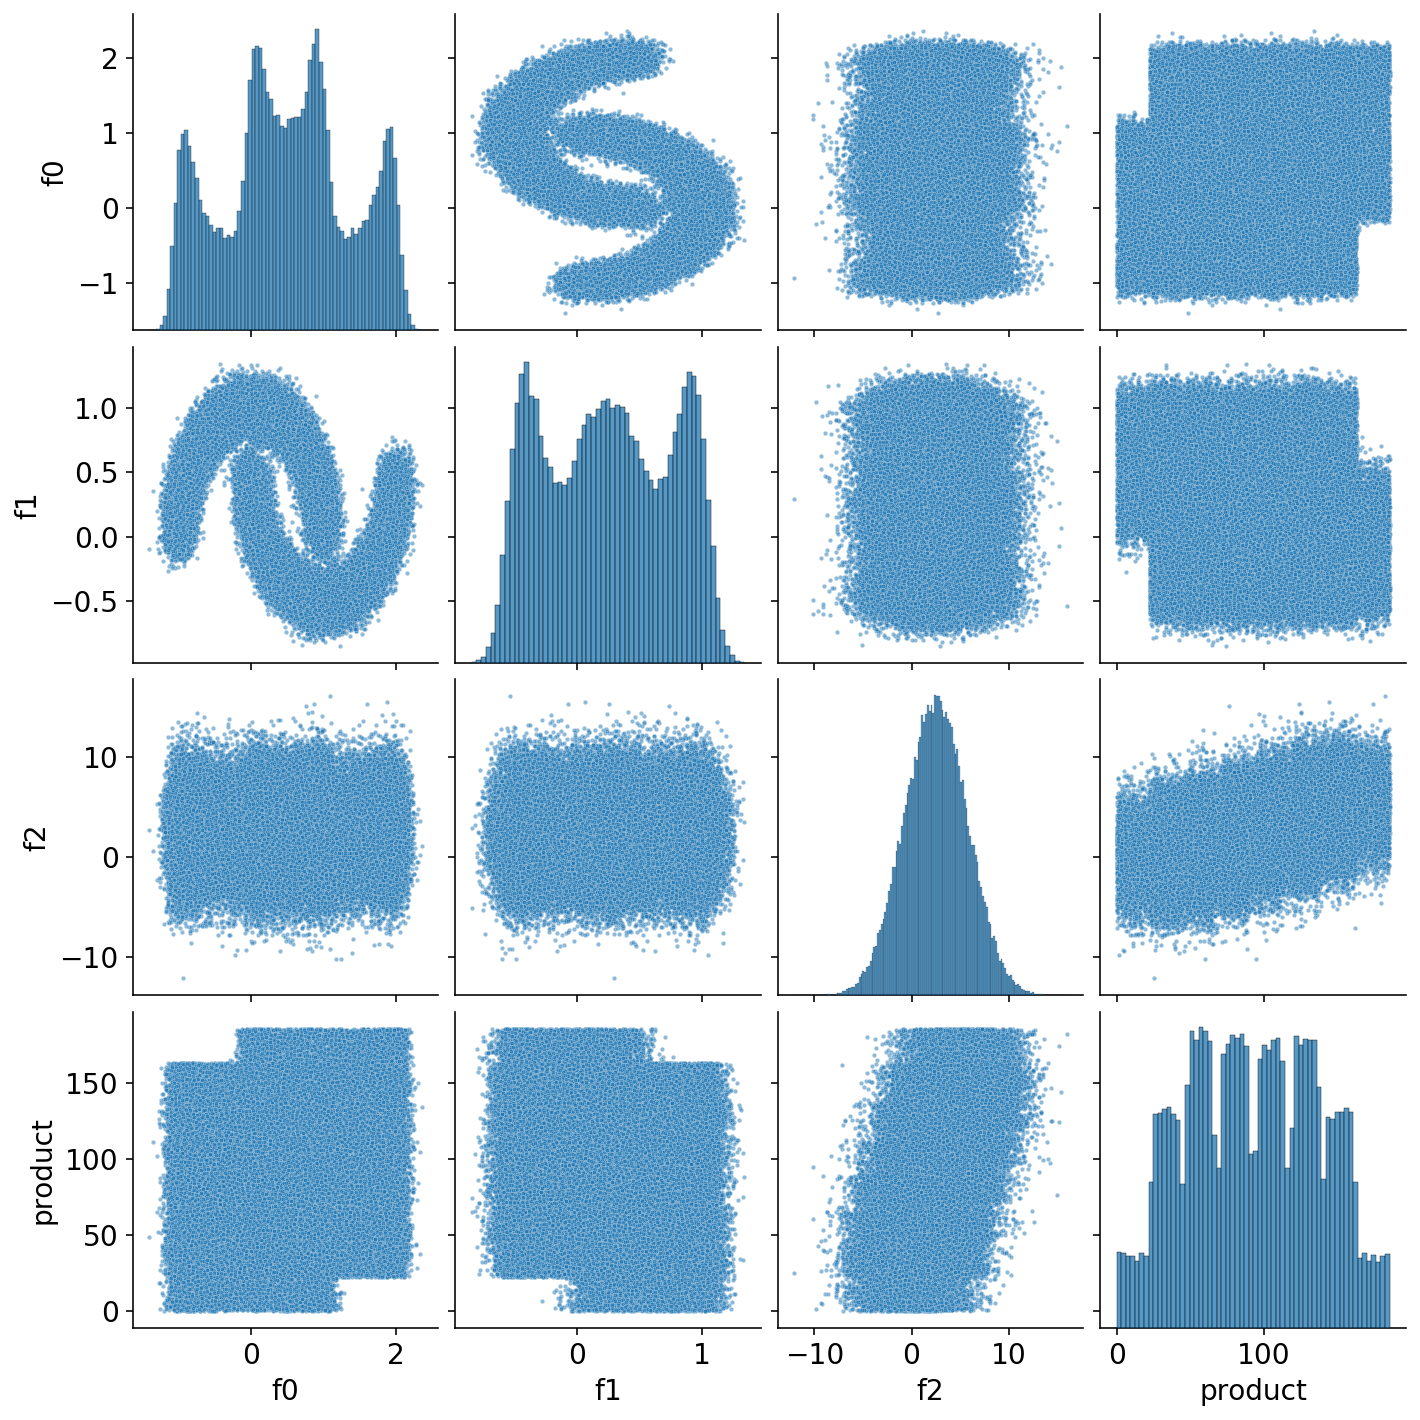

In [9]:
displayGeneralDataInfo(raw_geo_data_0)

Выведем первые 5 строк таблицы.



id      f0      f1     f2  product
0  kBEdx -15.001  -8.276 -0.006    3.179
1  62mP7  14.272  -3.475  0.999   26.953
2  vyE1P   6.263  -5.948  5.001  134.766
3  KcrkZ -13.081 -11.506  4.999  137.945
4  AHL4O  12.702  -8.147  5.004  134.766

Выведем общую информацию 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Посмотрим на значения, распределения в нашем DataFrame.



count   mean    std     min    25%    50%     75%     max
f0      100000.000  1.141  8.966 -31.610 -6.299  1.153   8.621  29.422
f1      100000.000 -4.797  5.120 -26.359 -8.268 -4.813  -1.333  18.734
f2      100000.000  2.495  1.704  -0.018  1.000  2.011   4.000   5.020
product 100000.000 68.825 45.944   0.000 26.953 57.086 107.813 137.945

Посмотрим на корреляцию.



f0     f1     f2  product
f0       1.000  0.182 -0.002   -0.030
f1       0.182  1.000 -0.003   -0.010
f2      -0.002 -0.003  1.000    0.999
product -0.030 -0.010  0.999    1.000

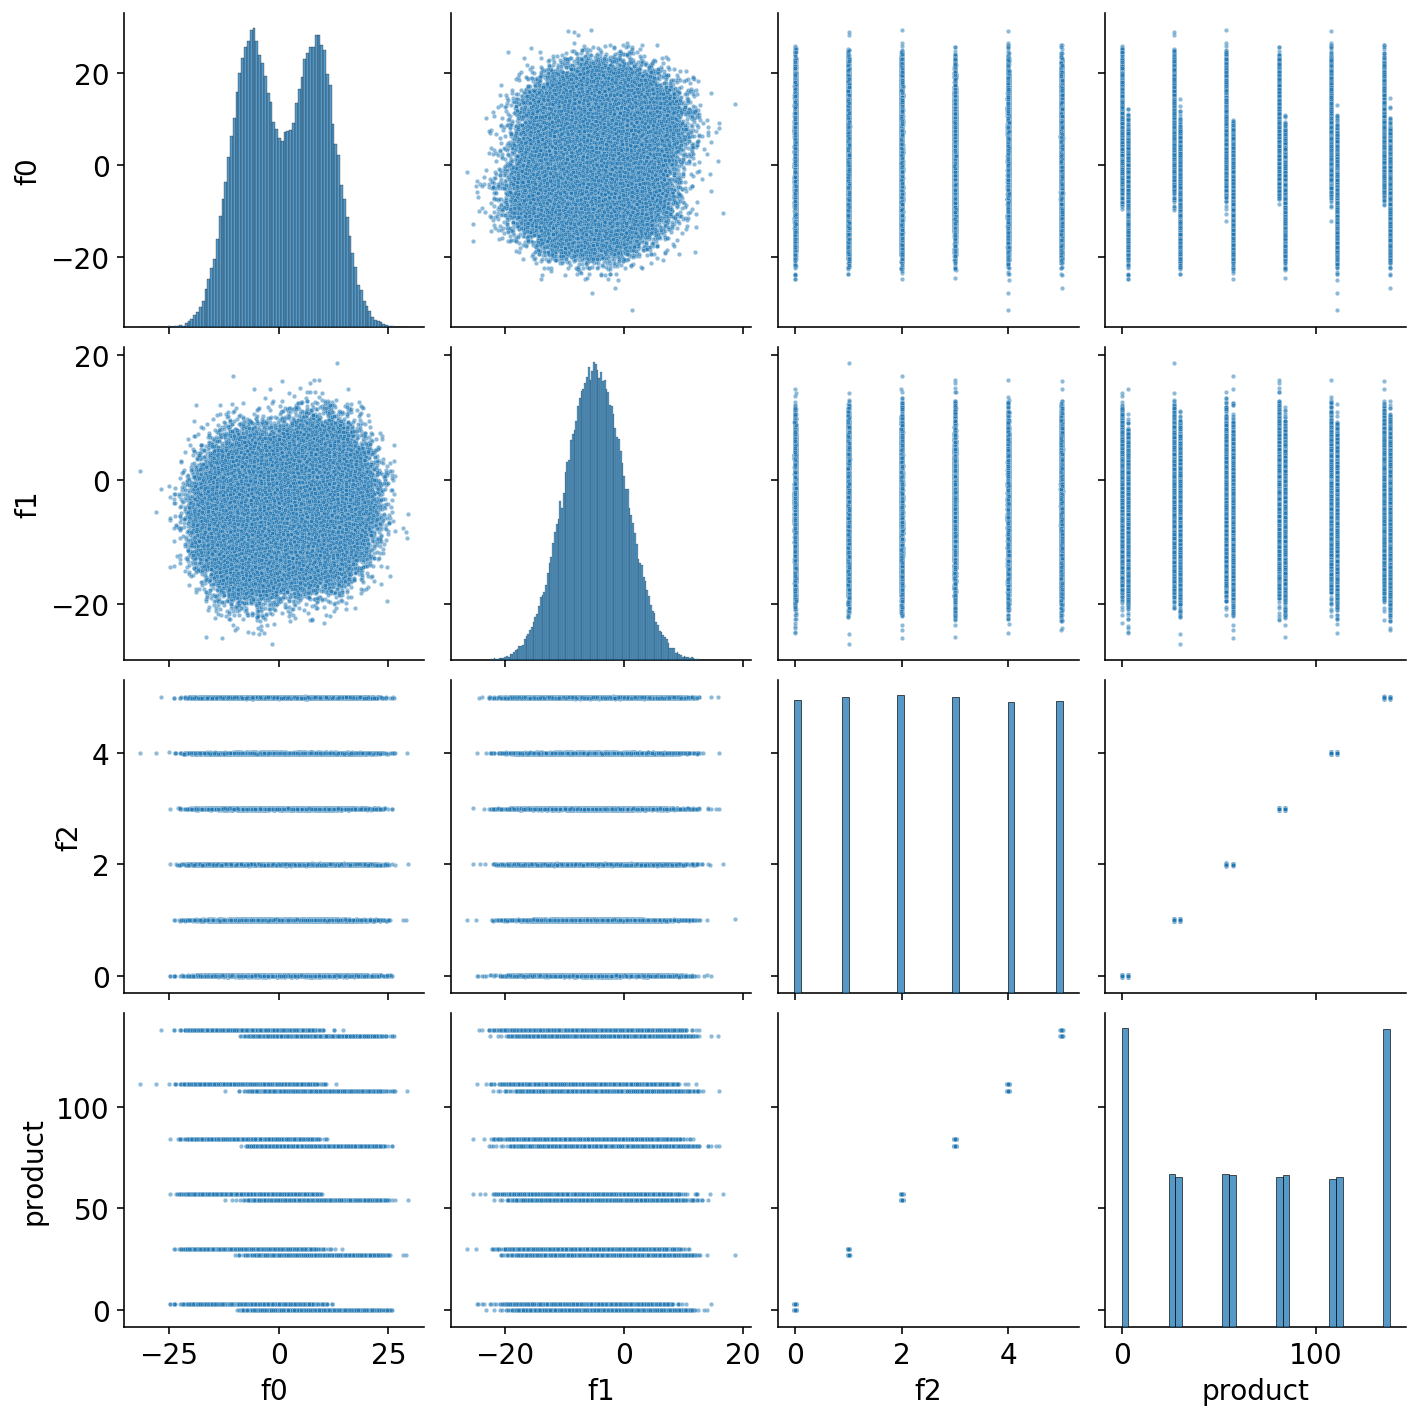

In [10]:
displayGeneralDataInfo(raw_geo_data_1)

Выведем первые 5 строк таблицы.



id     f0     f1     f2  product
0  fwXo0 -1.147  0.963 -0.829   27.759
1  WJtFt  0.263  0.270 -2.530   56.070
2  ovLUW  0.195  0.289 -5.586   62.872
3  q6cA6  2.236 -0.554  0.930  114.573
4  WPMUX -0.516  1.716  5.899  149.601

Выведем общую информацию 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Посмотрим на значения, распределения в нашем DataFrame.



count   mean    std     min    25%    50%     75%     max
f0      100000.000  0.002  1.732  -8.760 -1.162  0.009   1.159   7.238
f1      100000.000 -0.002  1.730  -7.084 -1.175 -0.009   1.164   7.845
f2      100000.000  2.495  3.473 -11.970  0.130  2.484   4.859  16.739
product 100000.000 95.000 44.750   0.000 59.450 94.926 130.595 190.030

Посмотрим на корреляцию.



f0     f1     f2  product
f0       1.000  0.001 -0.000   -0.002
f1       0.001  1.000  0.001   -0.001
f2      -0.000  0.001  1.000    0.446
product -0.002 -0.001  0.446    1.000

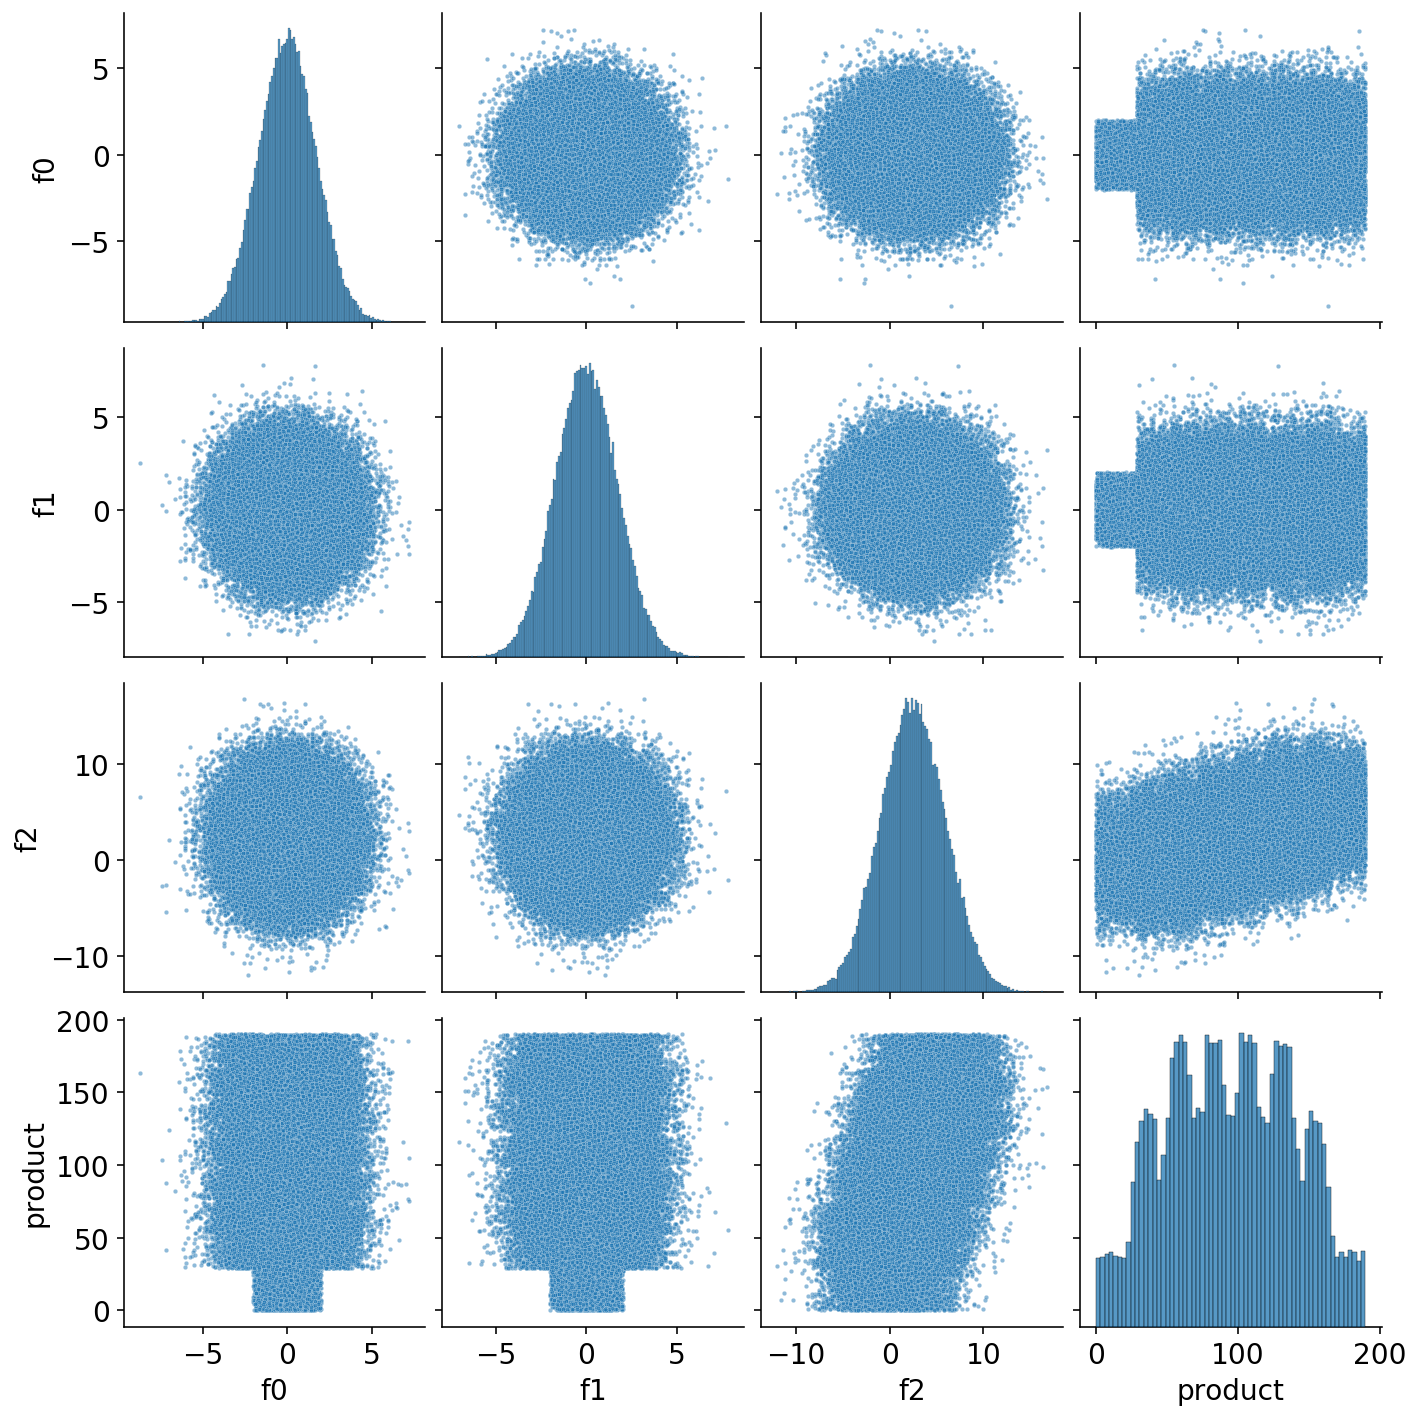

In [11]:
displayGeneralDataInfo(raw_geo_data_2)

Наблюдения по данным.

 |Датафрейм       |Комментарий
 |:---------------|:------------------------|
|raw_geo_data_0        |В данных нету пропущенных значений. Максимальный обьём запасов в одной из скважин - 185,364 баррелей. Минимальное значение - 0 баррелей, т.е встречаются места где нет нефти. Значительная дисперсия в столбце *products*. Среднее значение - 92,500 баррелей. Корреляций между признаками не было замечено.|
|raw_geo_data_1        |В данных нету пропущенных значений. Максимальный обьём запасов в одной из скважин - 137,945 баррелей.  Минимальное значение - 0 баррелей, т.е встречаются места где нет нефти. Значительная дисперсия в столбце *products*. Среднее значение - 68,825 баррелей. Замечена корреляция между признаком *f2* и целевым признаком *products*. |
|raw_geo_data_2        |В данных нету пропущенных значений. Максимальный обьём запас в одной из скважин - 190,030 баррелей. Минимальное значение - 0 баррелей, т.е встречаются места где нет нефти. Значительная дисперсия в столбце *products*. Среднее значение - 95,000 баррелей. Корреляцию определить не удалось.|

## Вывод

Во всех 3-х датафреймах нету пропущенных значений. Значительная дисперсия в столбце *products* в данных. Во втором регионе(*raw_geo_data_1*) была замечена корреляция между признаками *f2* и *products*. Минимальное значение - 0 баррелей, т.е встречаются места где нет нефти. Стоить заметить что столбец *id* будет не нужен. Уберем этот столбец на этапе предобработки данных. Отрицательных значений в столбце *products* нету. Признаки *f0,f1,f2* стандартизированы. Нам необходимо: 
1. Предобработать данные. Убрать лишний столбец. Проверить данные на дупликаты.
2. Обучить модель машинного обучения для каждого региона. В условиях задача было сказано ,что для обучения модели подходит только линейная регрессия. 
3. Подготовиться к расчёту прибыли.
4. Расчитать прибыли и риски в каждом регионе.
5. Выбрать регион для разработки скважин.

<br>

<a id="dataPreprocessing"></a>
# Этап 2 - Предобработка данных

На этапе предобработки данных, нам необходимо: 
1. Убрать лишние столбцы.
2. Проверка данных на дупликаты, отрицательные значения.
3. Разделить данные на обучающую и валидационную выборки.

<a id="removeColumns"></a>
## Удаление лишних столбцов

Уберём лишний столбец: *id*. Сохраним столбец в отдельном *Series*.

In [12]:
region1_id = raw_geo_data_0['id']
region2_id = raw_geo_data_1['id']
region3_id = raw_geo_data_2['id']

region1_data = raw_geo_data_0.drop(['id'], axis=1)
region2_data = raw_geo_data_1.drop(['id'], axis=1)
region3_data = raw_geo_data_2.drop(['id'], axis=1)

In [13]:
# Проверка
for region in [region1_data, region2_data,region3_data]:
    print(region.columns)

Index(['f0', 'f1', 'f2', 'product'], dtype='object')
Index(['f0', 'f1', 'f2', 'product'], dtype='object')
Index(['f0', 'f1', 'f2', 'product'], dtype='object')


<a id="dataCheck"></a>
## Проверка данных на дупликаты, отрицательные значения, пропущенные значения.

Напишем функцию которая проверит:
1. Пропущенные значения
2. Дупликаты
3. Есть ли отрицательные значения
4. Соответствующие типы данных float64

In [14]:
def get_preprocessed_data(raw_data):
    """
    Функция проверяет данные. Возвращает предобработанные данные для обучения.
    raw_data - данные для проверки
    """
    # проверяем данные
    assert raw_data.isna().sum().sum() == 0, 'В данных не должно быть пропущенных значений!'
    assert raw_data.select_dtypes(exclude=[np.float64]).size == 0, 'Данные должны иметь только численный тип данных!'
    assert raw_data.duplicated().sum().sum() == 0, 'В данных не должно быть дупликатов!'
    assert raw_data['product'].min().min() == 0,'В данных не должно быть отрицательных значений!'
    print('Данные проверку прошли!')
    #создаем копию оригинального датафрейма
    preprocessed_data = raw_data.copy()
    
    return preprocessed_data

In [15]:
# Проверяем первый регион
region1_data = get_preprocessed_data(region1_data)

Данные проверку прошли!


In [16]:
# Проверяем второй регион
region2_data = get_preprocessed_data(region2_data)

Данные проверку прошли!


In [17]:
# Проверяем третий регион
region3_data = get_preprocessed_data(region3_data)

Данные проверку прошли!


<a id="dataSeparation"></a>
## Разделение данных 

Нам необходимо проверить модель на правильные предсказания. Для этого мы разделим общую выборку на 2 части в соотношении (*75/25*): обучающую, валидационную.

Для начала напишем функцию разделения целевого признака от остальных.

In [18]:
def target_features_split(data,column):
    """
    Функция разделяет данные на целевой признак и признаки. Функция возвращает 1) целевой признак, 2) признаки без целевого
    data - данные которые необходимо разделить.
    column - целевой признак
    """
    return data[column], data.drop(column,axis=1)

Зафиксируем ***random_state***.

In [19]:
random_state_value = 42

In [20]:
region1_target, region1_features = target_features_split(region1_data,'product')
region2_target, region2_features = target_features_split(region2_data, 'product')
region3_target, region3_features = target_features_split(region3_data, 'product')

В sklearn есть функция для деления выборки *train_test_split()* воспользуемся ей. Разделим данные на две выборки: обучающую и валидационную. Напишем функцию для деления данных и печати размеров полученных наборов, чтобы избежать ошибок.

In [21]:
def sampleSize(original, train, valid):
    """
    Функция для печати полученных наборов.
    original - исходные данные
    train - обучающая выборка
    valid - валидационная выборка
    """
    print(f'Размер исходных данных {len(original)}')
    print(f'Размер тренировочной выборки {len(train)}')
    print(f'Размер валидационной выборки {len(valid)}')

In [22]:
def splitting_data(target,features):
    """
    Функция для разделения данных на обучающую и валидационную выборки. Функция возвращает признаки и целевой признак: 1) обучающей, 2) валидационной
    target - целевой признак
    features - признаки без целевого
    """
    features_train, features_valid, target_train, target_valid = train_test_split(features, target,
                                                                                            random_state=random_state_value,
                                                                                            test_size=0.25)
    # проверяем размеры выборок
    sampleSize(features, features_train, features_valid)
    return features_train, target_train, features_valid, target_valid

### Первый регион

In [23]:
region1_features_train, region1_target_train, region1_features_valid, region1_target_valid = splitting_data(region1_target, region1_features)

Размер исходных данных 100000
Размер тренировочной выборки 75000
Размер валидационной выборки 25000


### Второй регион

In [24]:
region2_features_train, region2_target_train, region2_features_valid, region2_target_valid = splitting_data(region2_target, region2_features)

Размер исходных данных 100000
Размер тренировочной выборки 75000
Размер валидационной выборки 25000


### Третий регион

In [25]:
region3_features_train, region3_target_train, region3_features_valid, region3_target_valid = splitting_data(region3_target, region3_features)

Размер исходных данных 100000
Размер тренировочной выборки 75000
Размер валидационной выборки 25000


## Вывод

На этапе предобработки данных, мы:
1. Убрали лишние столбцы
2. Сделали финальные проверки с помощью кастомной функции. Данные проверку прошли.
3. Разделили общую выборку на 2 части в соотношении (*75/25*): обучающую, валидационную.

Данные предобработаны и готовы к обучению моделей машинного обучения. 

<br>

<a id="MLmodelResearch"></a>
# Этап 3 - Исследование моделей машинного обучения

В условиях задача было сказано ,что для обучения модели подходит только линейная регрессия. Исследуем модель машинного обучения *Linear Regression*. Переберём гиперпараметры, посмотрим значения метрик:
1. MSE (средняя квадратичная ошибка) и RMSE (квадратный корень из средней квадратичной ошибки).
2. Коэффициент детерминации, или метрика R2
3. MAE

Сохраним предсказания модели и правильные ответы на валидационной выборке. Посчитаем средний запас предсказанного сырья и RMSE модели.

Мы будем вести учёт моделей машинного обучения. Создадим лист моделей с помощью словаря. Потом из словаря преобразуем таблицу моделей со всеми метриками. Также, необходимо сохранить предсказания модели и правильные ответы, поэтому создадим массивы, куда будем сохранять.

In [26]:
ml_models_stats = dict()

Напишем функцию для оценки моделей. Также создадим вспомогательные функции, например функции подсчёта среднего запаса сырья.

In [27]:
def calculateMeanProduct(region_data,region_number,predictions):
    """
    Функция для вычисления среднего запаса сырья по региону и среднего запаса предсказанного сырья. 
    Возвращает средний запас сырья по региону, средний запас предсказанного сырья, и разницу.
    region_data - данные по региону для вычисления среднего запаса сырья
    region_number - номер региона
    predictions - предсказания модели
    """
    # вычисление среднего запаса сырья по региону
    mean_region_product = region_data['product'].mean()
    # вычисление среднего запаса предсказанного сырья по региону
    mean_predicted_product = predictions.mean()
    # разница между средними
    mean_difference = mean_region_product - mean_predicted_product
    # вывод средних значений
    print(f'Среднее запаса сырья по региону #{region_number}: {mean_region_product}')
    print(f'Среднее запаса предсказанного сырья по региону #{region_number}: {mean_predicted_product}')
    print(f'Разница: {mean_difference}')
    
    return mean_region_product, mean_predicted_product,mean_difference

In [28]:
def evaluate_model(model_name, model, train_score, valid_score,features_valid, target_valid,region_data,region_number,parameters=None):
    """
    Функция оценивает модель по определенным метрикам, добавляет модель в таблицу со всеми метриками. Также, функция подсчитывает средний запас предсказанного сырья и RMSE модели
    Функция возвращает предсказания модели
    model_name - имя модели
    model - сама модель
    train_score - точность на обучающей выборке
    valid_score - точность на валидационной выборке
    features_valid - признаки на валидационной выборке
    target_valid - целевой признак на валидационной выборке
    region_data - данные по региону для вычисления среднего запаса сырья
    region_number - номер региона
    parameters - параметры модели
    """
    print(f'Оценка модели: {model_name}')
    if parameters:
        print(f'с параметрами: {parameters}')
    print()
    print(f'Точность модели на обучающей выборке: {train_score}')
    print(f'Точность модели на валидационной выборке: {valid_score}')
    
    # генерируем предсказания
    predicted_valid = model.predict(features_valid)
    # MSE - средняя квадратичная ошибка
    mse = mean_squared_error(target_valid, predicted_valid)
    # RMSE - квардратный корень из средней квадратичной ошибки
    rmse = mse ** 0.5
    # R2 - коэффициент детерминации
    r2 = r2_score(target_valid, predicted_valid)
    print()
    # MAE - среднее абсолютное отклонение
    mae = mean_absolute_error(target_valid, predicted_valid)
    # вывод значений метрик
    print(f'MSE модели: {mse}')
    print(f'RMSE модели: {rmse}')
    print(f'R2 модели: {r2}')
    print(f'MAE модели: {mae}')
    # вычисление среднего запаса сырья по региону и среднего запаса предсказанного сырья
    mean_region_product, mean_predicted_product,mean_difference = calculateMeanProduct(region_data, region_number,predicted_valid) 
    # добаляем модель
    ml_models_stats[model_name] = {
        'название': model_name,
        'обучающая_точность': train_score,
        'валидационная_точность': valid_score,
        'mse': mse,
        'rmse':rmse,
        'r2_score':r2,
        'mae':mae,
        'region': region_number,
        'mean_product_region': mean_region_product,
        'mean_predicted_product': mean_predicted_product,
        'mean_difference':mean_difference
    }
    print()
    print('Модель успешно добавлена в таблицу!')
    return predicted_valid

Начнём с первого региона

<a id="firstRegion"></a>
## Первый регион

### Линейная регрессия с параметрами по умолчанию.

In [29]:
# создаем модель
default_linear_region1_model = LinearRegression()
# тренируем модель
default_linear_region1_model.fit(region1_features_train, region1_target_train)
region1_default_predictions = evaluate_model('Линейная регрессия с дефолтными параметрами - регион 1', default_linear_region1_model, default_linear_region1_model.score(region1_features_train, region1_target_train),
              default_linear_region1_model.score(region1_features_valid, region1_target_valid),region1_features_valid, region1_target_valid,region1_data, 1)

Оценка модели: Линейная регрессия с дефолтными параметрами - регион 1

Точность модели на обучающей выборке: 0.2766525156889148
Точность модели на валидационной выборке: 0.2728287328173471

MSE модели: 1425.5608700093812
RMSE модели: 37.75660035026169
R2 модели: 0.2728287328173471
MAE модели: 31.047681538788183
Среднее запаса сырья по региону #1: 92.50000000000001
Среднее запаса предсказанного сырья по региону #1: 92.39879990657768
Разница: 0.10120009342233516

Модель успешно добавлена в таблицу!


Среднее запаса предсказанного сырья практически совпадает со среднем запасом сырья по региону. Что касается точности предсказаний, модель ошибается на 38 тыс. баррелей.

### Линейная регрессия с указанными параметрами.

In [30]:
# создаем модель
linear_region1_model = LinearRegression(n_jobs=-1, normalize=True)
# тренируем модель
linear_region1_model.fit(region1_features_train, region1_target_train)
region1_withParams_predictions = evaluate_model('Линейная регрессия с параметрами - регион 1', linear_region1_model, linear_region1_model.score(region1_features_train, region1_target_train),
              linear_region1_model.score(region1_features_valid, region1_target_valid),region1_features_valid, region1_target_valid,region1_data, 1, linear_region1_model.get_params())

Оценка модели: Линейная регрессия с параметрами - регион 1
с параметрами: {'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'normalize': True}

Точность модели на обучающей выборке: 0.2766525156889148
Точность модели на валидационной выборке: 0.2728287328173471

MSE модели: 1425.5608700093812
RMSE модели: 37.75660035026169
R2 модели: 0.2728287328173471
MAE модели: 31.047681538788183
Среднее запаса сырья по региону #1: 92.50000000000001
Среднее запаса предсказанного сырья по региону #1: 92.3987999065777
Разница: 0.10120009342232095

Модель успешно добавлена в таблицу!


Точность не увеличилась. Переходим ко второму региону.

<a id="secondRegion"></a>
## Второй регион

### Линейная регрессия с параметрами по умолчанию.

In [31]:
# создаем модель
default_linear_region2_model = LinearRegression()
# тренируем модель
default_linear_region2_model.fit(region2_features_train, region2_target_train)
region2_default_predictions = evaluate_model('Линейная регрессия с дефолтными параметрами - регион 2', default_linear_region2_model, default_linear_region2_model.score(region2_features_train, region2_target_train),
              default_linear_region2_model.score(region2_features_valid, region2_target_valid),region2_features_valid, region2_target_valid,region2_data, 2)

Оценка модели: Линейная регрессия с дефолтными параметрами - регион 2

Точность модели на обучающей выборке: 0.9996243943664361
Точность модели на валидационной выборке: 0.9996245232002449

MSE модели: 0.792598656639199
RMSE модели: 0.8902801001028828
R2 модели: 0.9996245232002449
MAE модели: 0.7170119535682544
Среднее запаса сырья по региону #2: 68.82500000000002
Среднее запаса предсказанного сырья по региону #2: 68.71287803913764
Разница: 0.1121219608623818

Модель успешно добавлена в таблицу!


Модель линейной регрессии по второму региону оказалась самой точной. Среднее запаса предсказанного сырья практически совпадает со средним запасом по региону. Модель ошибается всего на 890 баррелей. 

### Линейная регрессия с указанными параметрами.

In [32]:
# создаем модель
linear_region2_model = LinearRegression(n_jobs=-1, normalize=True)
# тренируем модель
linear_region2_model.fit(region2_features_train, region2_target_train)
region2_withParams_predictions = evaluate_model('Линейная регрессия с параметрами - регион 2', linear_region2_model, linear_region2_model.score(region2_features_train, region2_target_train),
              linear_region2_model.score(region2_features_valid, region2_target_valid),region2_features_valid, region2_target_valid,region2_data, 2,linear_region2_model.get_params())

Оценка модели: Линейная регрессия с параметрами - регион 2
с параметрами: {'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'normalize': True}

Точность модели на обучающей выборке: 0.9996243943664361
Точность модели на валидационной выборке: 0.9996245232002449

MSE модели: 0.7925986566391996
RMSE модели: 0.8902801001028832
R2 модели: 0.9996245232002449
MAE модели: 0.7170119535682545
Среднее запаса сырья по региону #2: 68.82500000000002
Среднее запаса предсказанного сырья по региону #2: 68.71287803913764
Разница: 0.1121219608623818

Модель успешно добавлена в таблицу!


Значения метрик не изменились. Переходим к третьему региону. 

<a id="thirdRegion"></a>
## Третий регион

### Линейная регрессия с параметрами по умолчанию.

In [33]:
# создаем модель
default_linear_region3_model = LinearRegression()
# тренируем модель
default_linear_region3_model.fit(region3_features_train, region3_target_train)
region3_default_predictions = evaluate_model('Линейная регрессия с дефолтными параметрами - регион 3', default_linear_region3_model, default_linear_region3_model.score(region3_features_train, region3_target_train),
              default_linear_region3_model.score(region3_features_valid, region3_target_valid),region3_features_valid, region3_target_valid,region3_data, 3)

Оценка модели: Линейная регрессия с дефолтными параметрами - регион 3

Точность модели на обучающей выборке: 0.19961334767324457
Точность модели на валидационной выборке: 0.19634705977280487

MSE модели: 1611.6910636385903
RMSE модели: 40.145872311342174
R2 модели: 0.19634705977280487
MAE модели: 32.896958610578054
Среднее запаса сырья по региону #3: 95.00000000000004
Среднее запаса предсказанного сырья по региону #3: 94.77102387765939
Разница: 0.22897612234065434

Модель успешно добавлена в таблицу!


Ой ой... точность совсем плоха. Может изменение параметров поможет ? Модель ошибается в предсказаниях на 40 тыс. баррелей.

### Линейная регрессия с указанными параметрами.

In [34]:
# создаем модель
linear_region3_model = LinearRegression(n_jobs=-1, normalize=True)
# тренируем модель
linear_region3_model.fit(region3_features_train, region3_target_train)
region3_withParams_predictions = evaluate_model('Линейная регрессия с параметрами - регион 3', linear_region3_model, linear_region3_model.score(region3_features_train, region3_target_train),
              linear_region3_model.score(region3_features_valid, region3_target_valid),region3_features_valid, region3_target_valid,region3_data, 3, linear_region3_model.get_params())

Оценка модели: Линейная регрессия с параметрами - регион 3
с параметрами: {'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'normalize': True}

Точность модели на обучающей выборке: 0.19961334767324457
Точность модели на валидационной выборке: 0.19634705977280464

MSE модели: 1611.6910636385905
RMSE модели: 40.14587231134218
R2 модели: 0.19634705977280464
MAE модели: 32.896958610578054
Среднее запаса сырья по региону #3: 95.00000000000004
Среднее запаса предсказанного сырья по региону #3: 94.77102387765939
Разница: 0.22897612234065434

Модель успешно добавлена в таблицу!


Точность осталось такой же...

Сохраняем предсказания и ответы

In [35]:
# предсказания
region1_predictions = region1_default_predictions
region2_predictions = region2_default_predictions
region3_predictions = region3_default_predictions

<a id="resultsRearchModel"></a>
## Результаты исследования моделей машинного обучения

Для начала, cоздадим функцию *drawPlot*, которая поможет нам в постройке графиков.

In [36]:
def drawPlot(df,x_axis, y_axis, x_label, y_label,plot_title, order_by=None):
    """
    Функция отрисовки графика
    df - данные
    x_axis - ось x
    y_axis - ось y
    x_label - название оси x
    y_label - название оси y
    plot_title - заголовок
    order - столбец по которому будет определяться порядок
    """
    # Заголовок
    plt.title(plot_title)
    sns.barplot(x=x_axis,y=y_axis, data=df,order=df[order_by])
    # подписать оси 
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

Создадим таблицу из полученных данных.

In [37]:
ml_models = pd.DataFrame.from_dict(data=ml_models_stats, orient='index').reset_index(drop=True)
ml_models

название  обучающая_точность  \
0  Линейная регрессия с дефолтными параметрами - ...               0.277   
1        Линейная регрессия с параметрами - регион 1               0.277   
2  Линейная регрессия с дефолтными параметрами - ...               1.000   
3        Линейная регрессия с параметрами - регион 2               1.000   
4  Линейная регрессия с дефолтными параметрами - ...               0.200   
5        Линейная регрессия с параметрами - регион 3               0.200   

   валидационная_точность      mse   rmse  r2_score    mae  region  \
0                   0.273 1425.561 37.757     0.273 31.048       1   
1                   0.273 1425.561 37.757     0.273 31.048       1   
2                   1.000    0.793  0.890     1.000  0.717       2   
3                   1.000    0.793  0.890     1.000  0.717       2   
4                   0.196 1611.691 40.146     0.196 32.897       3   
5                   0.196 1611.691 40.146     0.196 32.897       3   

   mean_product_region  mean_predicted_product  mean_difference  
0               92.500                  92.399            0.101  
1               92.500                  92.399            0.101  
2               68.825                  68.713            0.112  
3               68.825                  68.713            0.112  
4               95.000                  94.771            0.229  
5               95.000                  94.771            0.229

Сгруппируем данные по регионам.

In [38]:
region_grouped_models = ml_models.groupby('region').max()

Найдем регион , где модель *Линейной регрессии*, которая показала хороший результат на R2 метрике.

region  r2_score
0       2     1.000
1       1     0.273
2       3     0.196

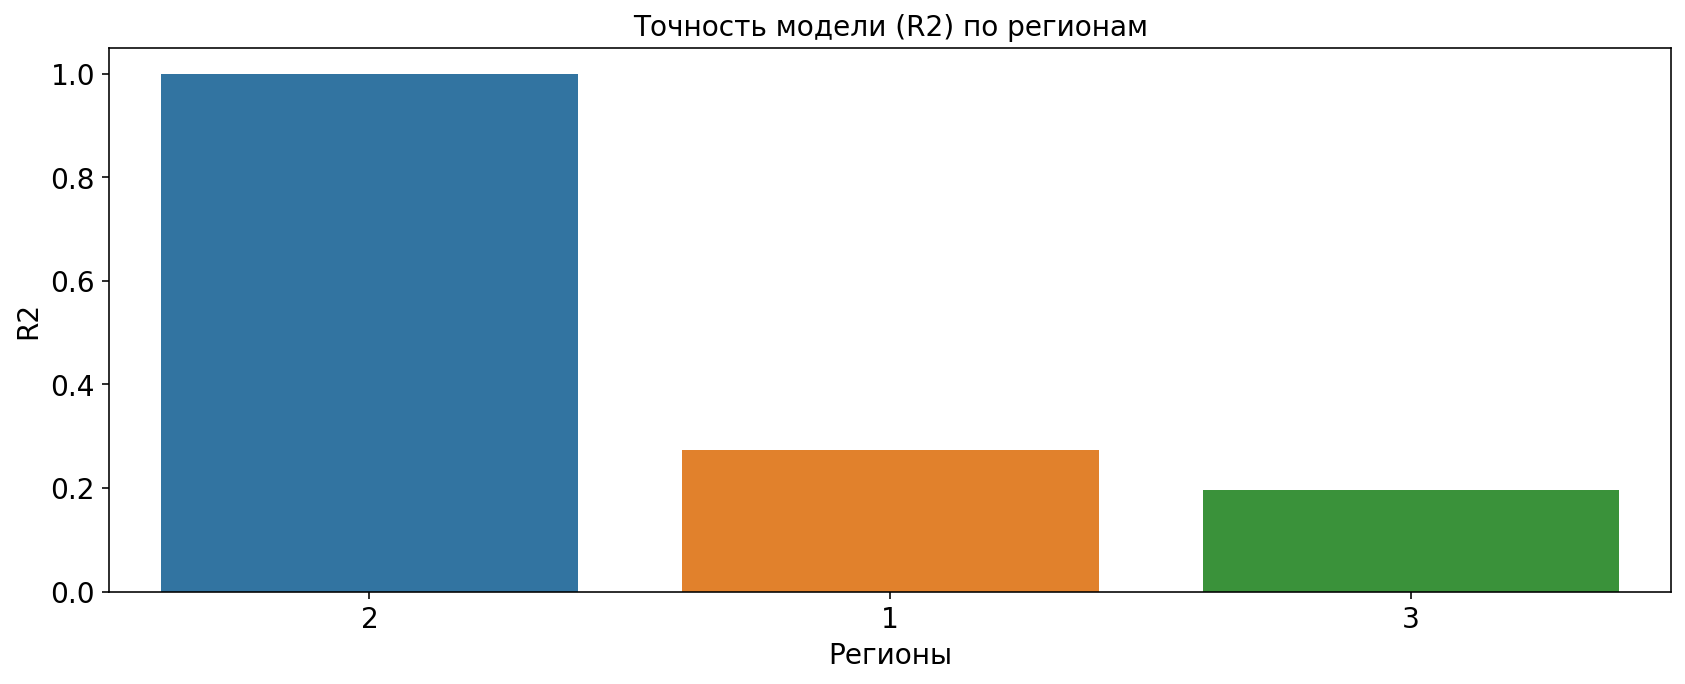

In [39]:
region_grouped_models_r2_sorted = region_grouped_models.sort_values(by='r2_score',ascending=False).reset_index()
display(region_grouped_models_r2_sorted[['region','r2_score']])
# Рисуем график
drawPlot(region_grouped_models_r2_sorted, 'region','r2_score','Регионы','R2','Точность модели (R2) по регионам','region' )

На графике видно, что во втором регионе модель *Линейной регрессии* была точна в предсказаниях - **1.00**. Предполагаю точность модели во втором регионе как-то связана с коррелацией в признаках(*f2*,*products*) которые мы нашли на этапе обзора данных. В остальных регионах точность была около ~ от **0.2** до **0.3**.

Теперь посмотрим на метрику *RMSE*.

region   rmse
0       3 40.146
1       1 37.757
2       2  0.890

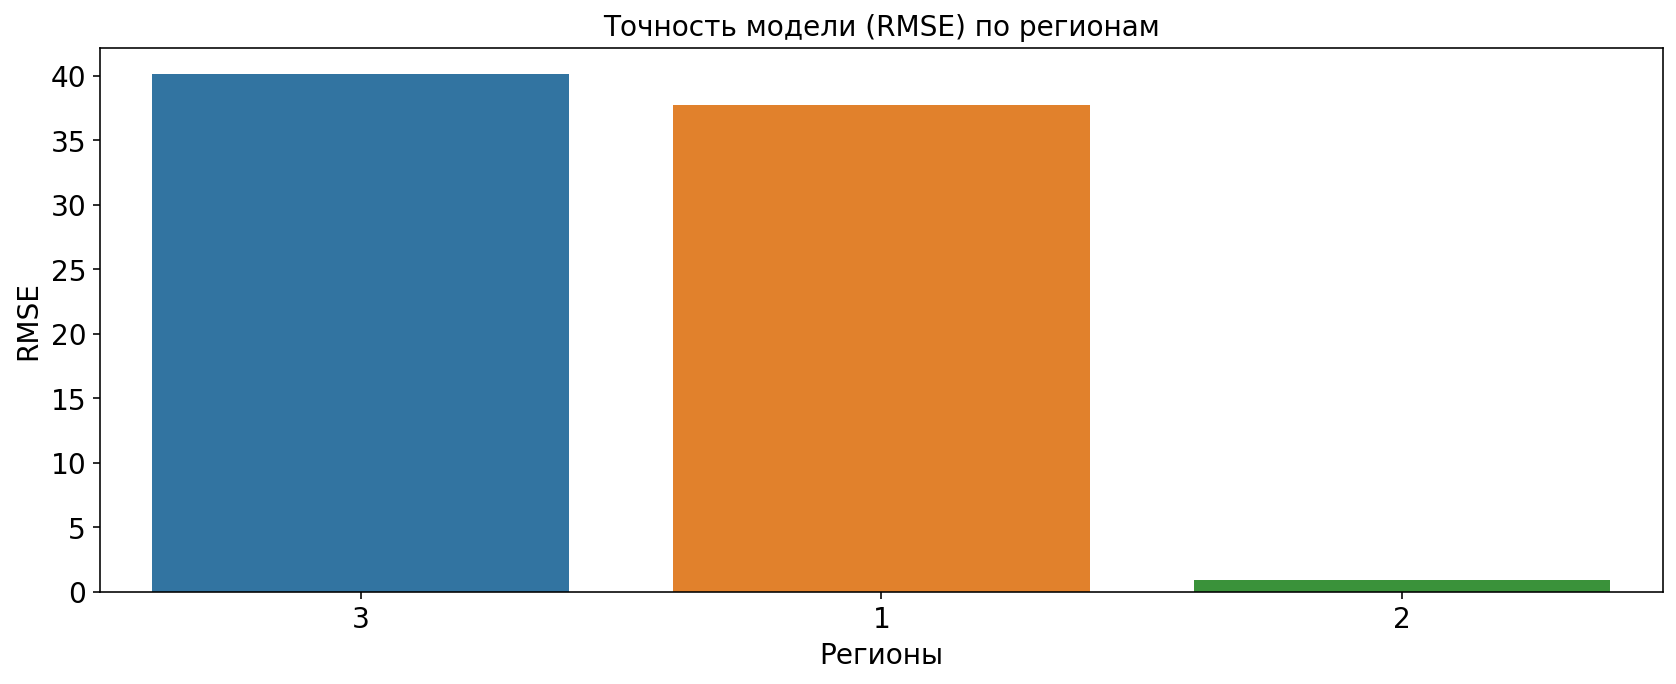

In [40]:
region_grouped_models_rmse_sorted = region_grouped_models.sort_values(by='rmse',ascending=False).reset_index()
display(region_grouped_models_rmse_sorted[['region','rmse']])
# Рисуем график
drawPlot(region_grouped_models_rmse_sorted, 'region','rmse','Регионы','RMSE','Точность модели (RMSE) по регионам','region')

Модели из первого и третьего региона ошибаются на ~**40 тыс. баррелей**. Тем временем, модель из второго региона ошибается всего на ~**890 баррелей**.

Посмотрим на метрику среднего абсолютного значения (MAE).

region    mae
0       3 32.897
1       1 31.048
2       2  0.717

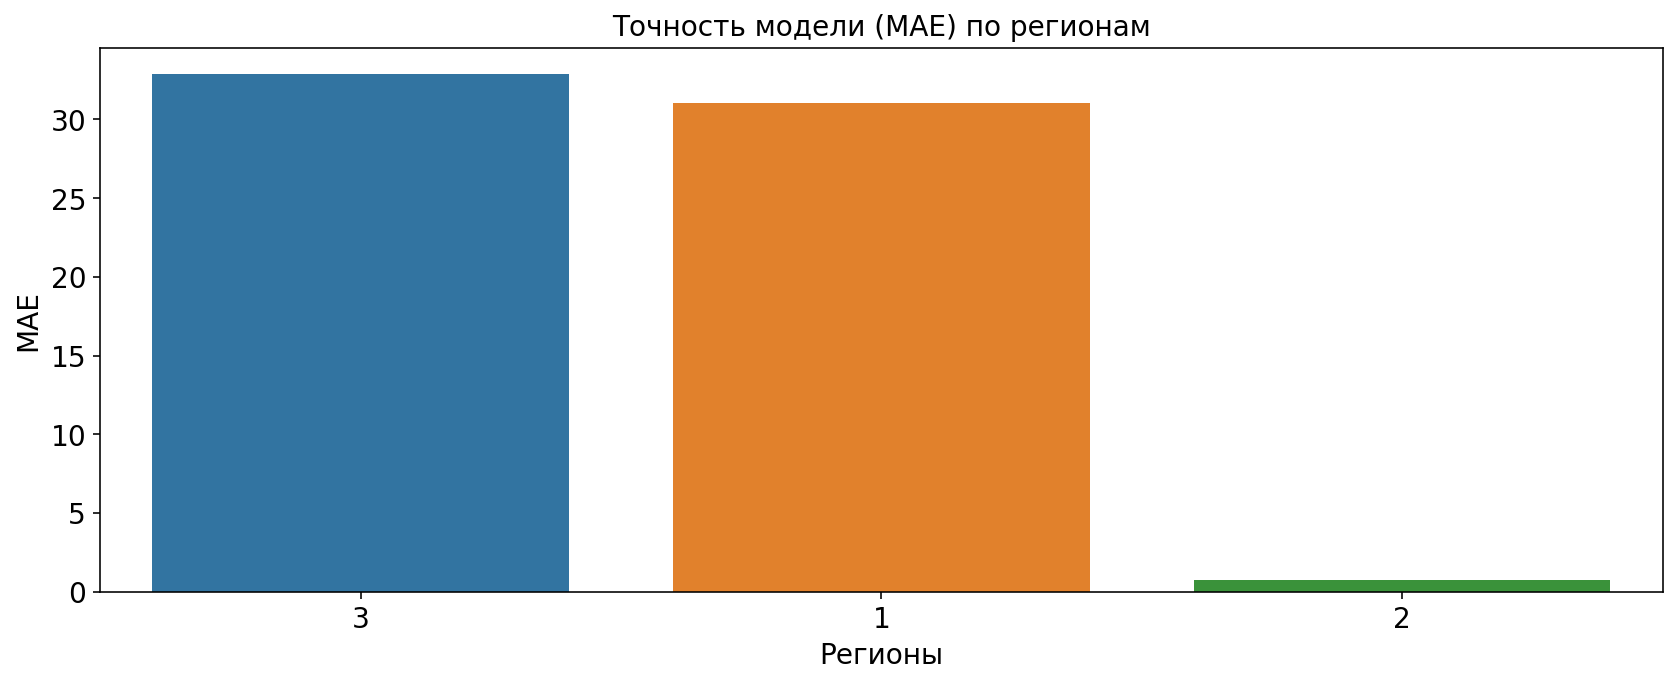

In [41]:
region_grouped_models_mae_sorted = region_grouped_models.sort_values(by='mae',ascending=False).reset_index()
display(region_grouped_models_mae_sorted[['region','mae']])
# Рисуем график
drawPlot(region_grouped_models_mae_sorted, 'region','mae','Регионы','MAE','Точность модели (MAE) по регионам','region')

Как видим, модели из третьего и первого региона ошибаются на **30 тыс. баррелей**. Тем временем, модель из второго всего **717 баррелей**.

Давайте посмотрим на различия средних значений по запасам.

region  mean_product_region  mean_predicted_product  mean_difference
0       3               95.000                  94.771            0.229
1       2               68.825                  68.713            0.112
2       1               92.500                  92.399            0.101

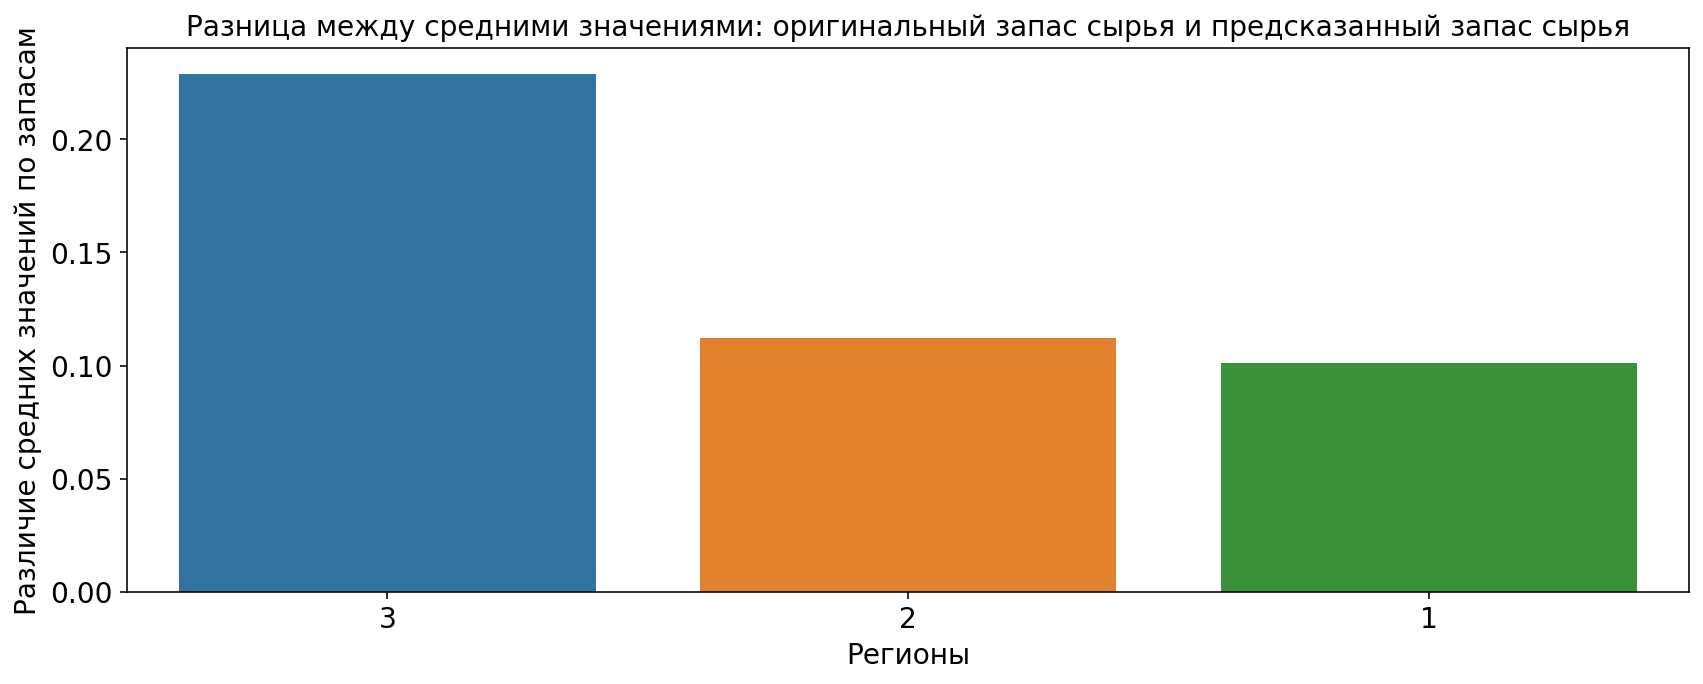

In [42]:
region_grouped_models_mean_difference_sorted = region_grouped_models.sort_values(by='mean_difference',ascending=False).reset_index()
display(region_grouped_models_mean_difference_sorted[['region','mean_product_region','mean_predicted_product','mean_difference']])
# Рисуем график
drawPlot(region_grouped_models_mean_difference_sorted,'region','mean_difference','Регионы'
         ,'Различие средних значений по запасам','Разница между средними значениями: оригинальный запас сырья и предсказанный запас сырья','region')

У моделей из третьего региона разница (**229 баррелей**) между средними превоcходит в два раза чем у моделей из первого(**101 баррль**) и второго регионов(**112 баррелей**).

## Вывод

На этом этапе мы провели исследование модели машинного обучения Linear Regression. Перебрали гиперпараметры, посмотрели значения метрик:
1. RMSE (квадратный корень из средней квадратичной ошибки). Модели из первого и третьего региона ошибаются на ~**40 тыс. баррелей**. Тем временем, модель из второго региона ошибается всего на ~**890 баррелей**.
2. Коэффициент детерминации, или метрика R2. втором регионе модель *Линейной регрессии* была точна в предсказаниях - **1.00**. Предполагаю точность модели во втором регионе как-то связана с коррелацией в признаках(*f2*,*products*) которые мы нашли на этапе обзора данных. В остальных регионах точность была около ~ от **0.2** до **0.3**.
3. MAE. Модели из третьего и первого региона ошибаются на **30 тыс. баррелей**. Тем временем, модель из второго всего **717 баррелей**.

Посчитали средний запас предсказанного сырья. У моделей из третьего региона разница (**229 баррелей**) между средними превоcходит в два раза чем у моделей из первого(**101 баррль**) и второго регионов(**112 баррелей**).

<br>

<a id="prepCalcProfit"></a>
# Этап 4 - Подготовка к расчёту прибыли

На этом этапе необходимо подготовиться к расчёту прибыли:
1. Необходимо рассчитать достаточный обьём сырья для безубыточной разработки новой скважины. 
2. Сравним полученный обьём сырья со средним запасом в каждом регионе. 

Сохраним все ключевые значения для расчётов в отдельных переменных.

1. *Бюджет на разработку скважин в регионе* — **10 млрд рублей**.
2. *Баррель сырья приносит* - **450 рублей дохода**.
3. *Доход с каждой единицы продукта составляет* - **450 тыс. рублей**, *поскольку обьём указан в тысячах баррелей*.
4. *При разведке региона исследуют* -  **500 точек**, из которых с помощью машинного обучения отбирают **200 точек**

In [43]:
# Бюджет на разработку скважин
BUDGET = 10000000000
# Прибыль с одного барреля сырья
PROFIT_PER_UNIT = 450
# Прибыль с каждой единицы продутка
PROFIT_PER_PRODUCT_UNIT = 450000
# Количество точек для исследования
TOTAL_PLACES_PER_REGION = 500
# Топ 200
TOP_200_PLACES = 200

<a id="nonLossVolumeEstimation"></a>
## Подсчёт достаточного обьёма сырья для безубыточной разработки новой скважины

Посчитаем сколько стоит разработка одной скважины. Бюджет поделим на 200 точек скважин

In [44]:
cost_per_well = BUDGET / 200
print(f'Необходимо {cost_per_well} рублей для разработки одной скважины')

Необходимо 50000000.0 рублей для разработки одной скважины


50 миллинов рублей нужно для разработки одной скважины. Рассчитаем достаточный обьём сырья для безубыточной разработки новой скважины.

In [45]:
volume_per_well = round(cost_per_well / PROFIT_PER_PRODUCT_UNIT, 3)
print(f'Необходимо {volume_per_well} тыс. баррелей для безубыточной разработки новой скважины')

Необходимо 111.111 тыс. баррелей для безубыточной разработки новой скважины


<a id="averageVolumeComparison"></a>
## Сравнение со средним запасом в каждом регионе

Возьмём данные по трём регионам

In [46]:
regions_mean_product = region_grouped_models.reset_index()

Берём столбцы с регионом и средним запасом сырья

In [47]:
regions_mean_product = regions_mean_product[['region','mean_product_region']]

Добавляем к полученному датафрейму минимум сырья для безубыточной разработки новой скважины

In [48]:
# создаем датафрейм
desired_volume = pd.DataFrame({'region':['Безубыточная разработка'], 'mean_product_region':[volume_per_well]})
# добавляем к датафрейму со средним по каждому региону
regions_mean_product = pd.concat([regions_mean_product, desired_volume])

region  mean_product_region
0                        1               92.500
1                        2               68.825
2                        3               95.000
0  Безубыточная разработка              111.111

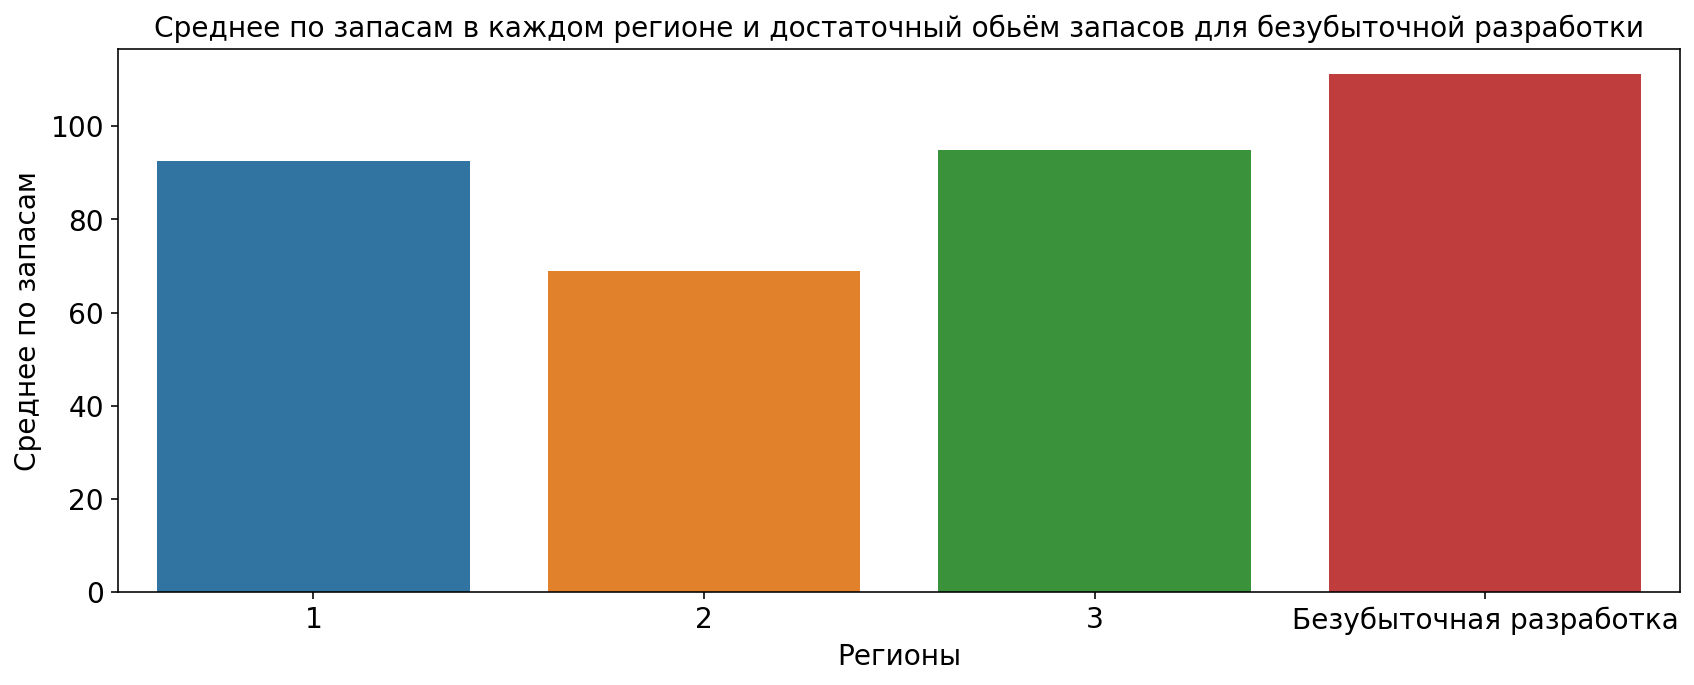

In [49]:
display(regions_mean_product)
# Рисуем график
drawPlot(regions_mean_product,'region','mean_product_region','Регионы'
         ,'Среднее по запасам','Среднее по запасам в каждом регионе и достаточный обьём запасов для безубыточной разработки','region')

На графике и таблице, мы видим что средних запасов сырья в каждом регионе недостаточно для безубыточной разработки. У нас есть убыточные скважины в каждом регионе. Следовательно, необходимо исследовать 500 точек, из которых с помощью машинного обучения выбирем 200 лучших для разработки.

## Вывод

На этом этапе мы:
1. Посчитали сколько необходимо бюджета для разработки одной скважины. **50 миллинов рублей** нужно для разработки одной скважины 
2. Рассчитали достаточный обьём сырья для безубыточной разработки новой скважины. Необходимо **111.111 тыс. баррелей** для безубыточной разработки новой скважины 
3. Сравнили полученный обьём сырья со средним запасом в каждом регионе. Cредних запасов сырья в каждом регионе не хватает для безубыточной разработки. У нас есть убыточные скважины в каждом регионе. Следовательно, необходимо исследовать 500 точек, из которых с помощью машинного обучения выбирем 200 лучших для разработки.

<br>

<a id="functionProfitEstimation"></a>
# Этап 5 - Функция для расчёта прибыли

На этом этапе необходимо:
1. Написать функцию для расчёта прибыли по выбранным скважинам и предсказаниям.
2. Выбрать скважины с максимальными значениями предсказаний
3. Просуммировать целевое значение объёма сырья, соответствующее этим предсказаниям
4. Рассчитайте прибыль для полученного объёма сырья

*При разведке региона исследуют* -  **500 точек**, из которых с помощью машинного обучения отбирают **200 точек**

In [50]:
def getTop200(target,predictions):
    """
    Функция выбирает 200 лучших точек
    target - целевой признак
    predictions - предсказания модели
    """
    predictions_sorted = pd.Series(predictions,index=target.index).sort_values(ascending=False)
    # выбираем 200 лучших точек
    selected = target[predictions_sorted.index][:TOP_200_PLACES]
    return selected

In [51]:
def displayProfit(profit,region):
    """
    Функция для вывода прибыли
    profit - прибыль
    region - регион
    """
    billions_formatted = round(profit / 1000000000,3)
    print(f'Прибыль для полученного обьёма сырья из {region}: {billions_formatted} млрд. рублей')

In [52]:
def estimateProfit(target,predictions, cost_per_well,region,is_bootstraped=False):
    """
    Функция для расчёта прибыли по выбраным скважинам и предсказаниям
    target - целевой признак
    predictions - предсказания модели
    cost_per_well - количество рублей нужно для разработки одной скважины
    region - регион
    is_bootstraped - вычисляем ли техникой Bootstrap
    """
    top_200 = getTop200(target,predictions)
    # просуммируем целевое значение обьёма сырья
    total_volume = top_200.sum()
    # посчитаем выручку
    revenue = total_volume * PROFIT_PER_PRODUCT_UNIT
    # считаем затраты
    cost = cost_per_well * TOP_200_PLACES
    # считаем прибыль
    profit = round(revenue - cost,3)
    # выводим прибыль
    if(not(is_bootstraped)):
        displayProfit(profit,region)
    return profit

Начнём с первого региона

### Регион - 1

In [53]:
region1_profit = estimateProfit(region1_target_valid,region1_predictions,cost_per_well,'Регион 1')

Прибыль для полученного обьёма сырья из Регион 1: 3.359 млрд. рублей


### Регион - 2

In [54]:
region2_profit = estimateProfit(region2_target_valid, region2_predictions,cost_per_well,'Регион 2')

Прибыль для полученного обьёма сырья из Регион 2: 2.415 млрд. рублей


### Регион - 3

In [55]:
region3_profit = estimateProfit(region3_target_valid, region3_predictions,cost_per_well,'Регион 3')

Прибыль для полученного обьёма сырья из Регион 3: 2.599 млрд. рублей


<a id="resultsNonRandom"></a>
## Результаты без выбора 500 случайных точек

Создадим таблицу из полученных данных.

region  profit
0       1   3.359
1       2   2.415
2       3   2.599

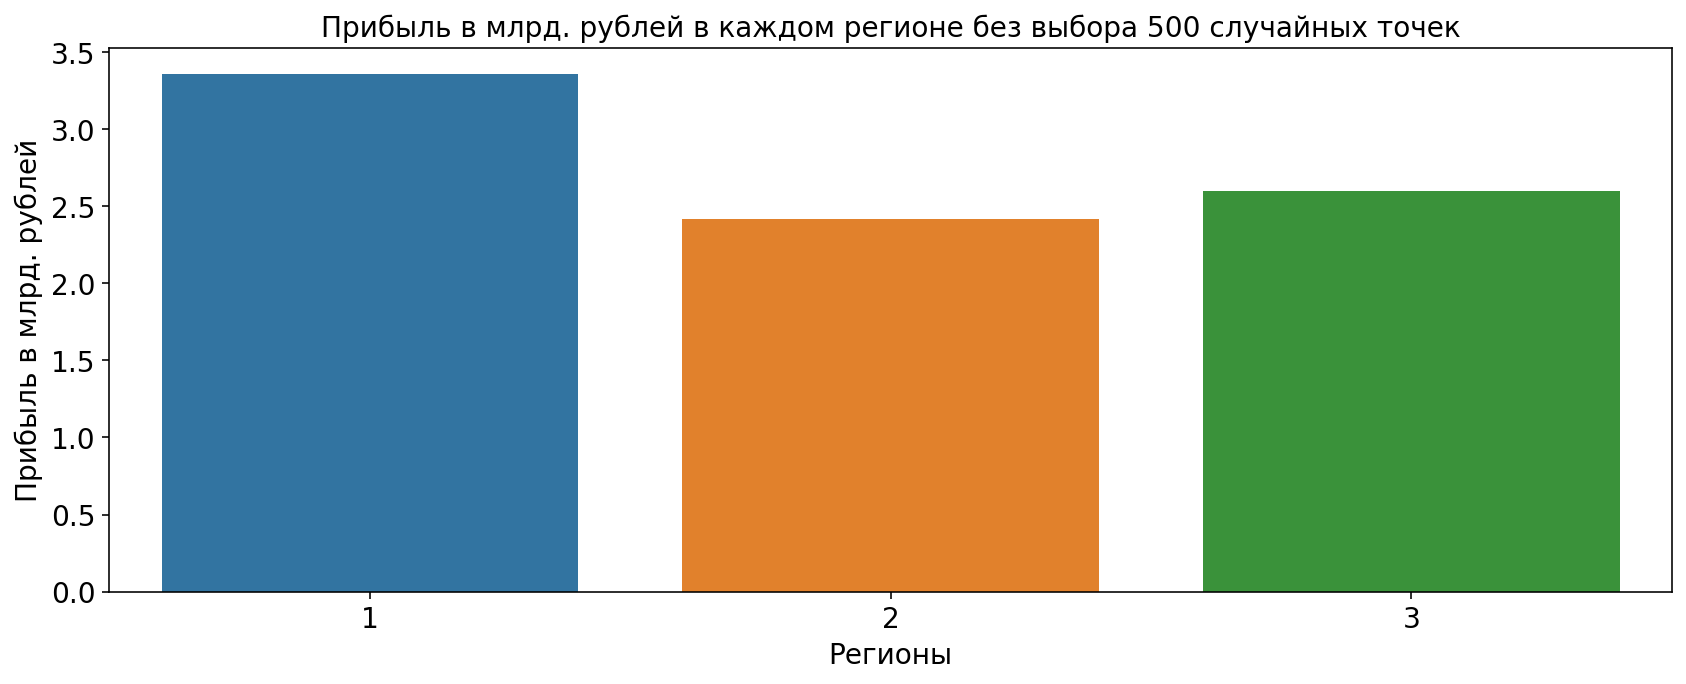

In [56]:
region_profit_non_random = pd.DataFrame({'region':[1,2,3],'profit': [region1_profit,region2_profit,region3_profit]})
region_profit_non_random.profit = round(region_profit_non_random.profit / 1000000000,3)
display(region_profit_non_random)
drawPlot(region_profit_non_random,'region','profit','Регионы'
         ,'Прибыль в млрд. рублей','Прибыль в млрд. рублей в каждом регионе без выбора 500 случайных точек','region')

Без выборки 500 случайных точек, видим на графике, что больше всего прибыли получилось в первом регионе ~**3.359 млрд. рублей**. Во втором и третьем - ~**2.415 млрд. рублей**,**2.599 млрд. рублей** соответственно.

## Вывод

На этом этапе мы написали функцию для расчёта прибыли. Выяснили ,что без выборки 500 случайных точек, больше всего прибыли получилось в первом регионе ~**3.359 млрд. рублей**. Во втором и третьем - ~**2.415 млрд. рублей**, **2.599 млрд. рублей** соответственно.  Перейдём к расчёту прибыли и рисков с выбором 500 случайных точек.

<a id="profitRiskEstimation"></a>
# Этап 6 - Расчёт прибыли и рисков

На этом этапе применим технику *Bootstrap* с 1000 выборок, что позволит найти распределение прибыли. Также, найдем среднюю прибыль, *95%* доверительный интервал, и риск убытков. Основываясь на результатах, предложим регион для разработки скважин.

Напишем функцию для расчёта прибыли техникой *Bootstrap*.

In [57]:
def bootstrapedProfit(target,predictions,cost_per_well,region):
    """
    Функция для расчёта техникой Bootstrap
    target - целевой признак
    predictions - предсказания
    cost_per_well - количество рублей нужно для разработки одной скважины
    region - регион
    """
    profits = []
    state = np.random.RandomState(random_state_value)
    # Выполняем процедуру bootstrap 1000 раз
    for i in range(1000):
        # выбираем 500 случайных точек
        target_subsample = target.sample(n=TOTAL_PLACES_PER_REGION, random_state=state,replace=True)
        # выбираем предсказания основываясь на индрексах target_subsample
        predictions_subsample = pd.Series(predictions)[target_subsample.index]
        profits.append(estimateProfit(target_subsample,predictions_subsample,cost_per_well,region,True))
        
    return profits

Расчитаем прибыль техникой *Bootstrap* для каждого региона.

In [58]:
# Регион - 1
region1_profits = bootstrapedProfit(region1_target_valid.reset_index(drop=True),region1_predictions,cost_per_well,'Регион 1')
# Регион - 2
region2_profits = bootstrapedProfit(region2_target_valid.reset_index(drop=True),region2_predictions,cost_per_well,'Регион 2')
# Регион - 3
region3_profits = bootstrapedProfit(region3_target_valid.reset_index(drop=True),region3_predictions,cost_per_well,'Регион 3')

Создадим таблицу из полученных данных

In [59]:
regions_profits = pd.DataFrame({'region_1':region1_profits,'region_2':region2_profits,'region_3':region3_profits})
regions_profits.head()

region_1      region_2      region_3
0 571778059.830 763805526.223   9500244.226
1 -58379450.081 563335463.982 112175798.328
2 437726679.579 734509404.810 468972408.973
3 306234241.345 -38136922.576 126196597.853
4 633507201.188 858722471.610 569369504.495

<a id="meanProfitBootstrap"></a>
## Средняя прибыль в каждом регионе - Bootstrap

Посчитаем среднюю прибыль в каждом регионе

### Первый регион

In [60]:
region1_profit = round(regions_profits['region_1'].mean() / 1000000,3)
print(f'Средняя прибыль в первом регионе: {region1_profit} млн. рублей')

Средняя прибыль в первом регионе: 427.848 млн. рублей


### Второй регион

In [61]:
region2_profit = round(regions_profits['region_2'].mean() / 1000000,3)
print(f'Средняя прибыль во втором регионе: {region2_profit} млн. рублей')

Средняя прибыль во втором регионе: 511.363 млн. рублей


### Третий регион

In [62]:
region3_profit = round(regions_profits['region_3'].mean() / 1000000,3)
print(f'Средняя прибыль в третьем регионе: {region3_profit} млн. рублей')

Средняя прибыль в третьем регионе: 402.576 млн. рублей


Создадим таблицу из полученных данных.

regions  mean_profit
0        1      427.848
1        2      511.363
2        3      402.576

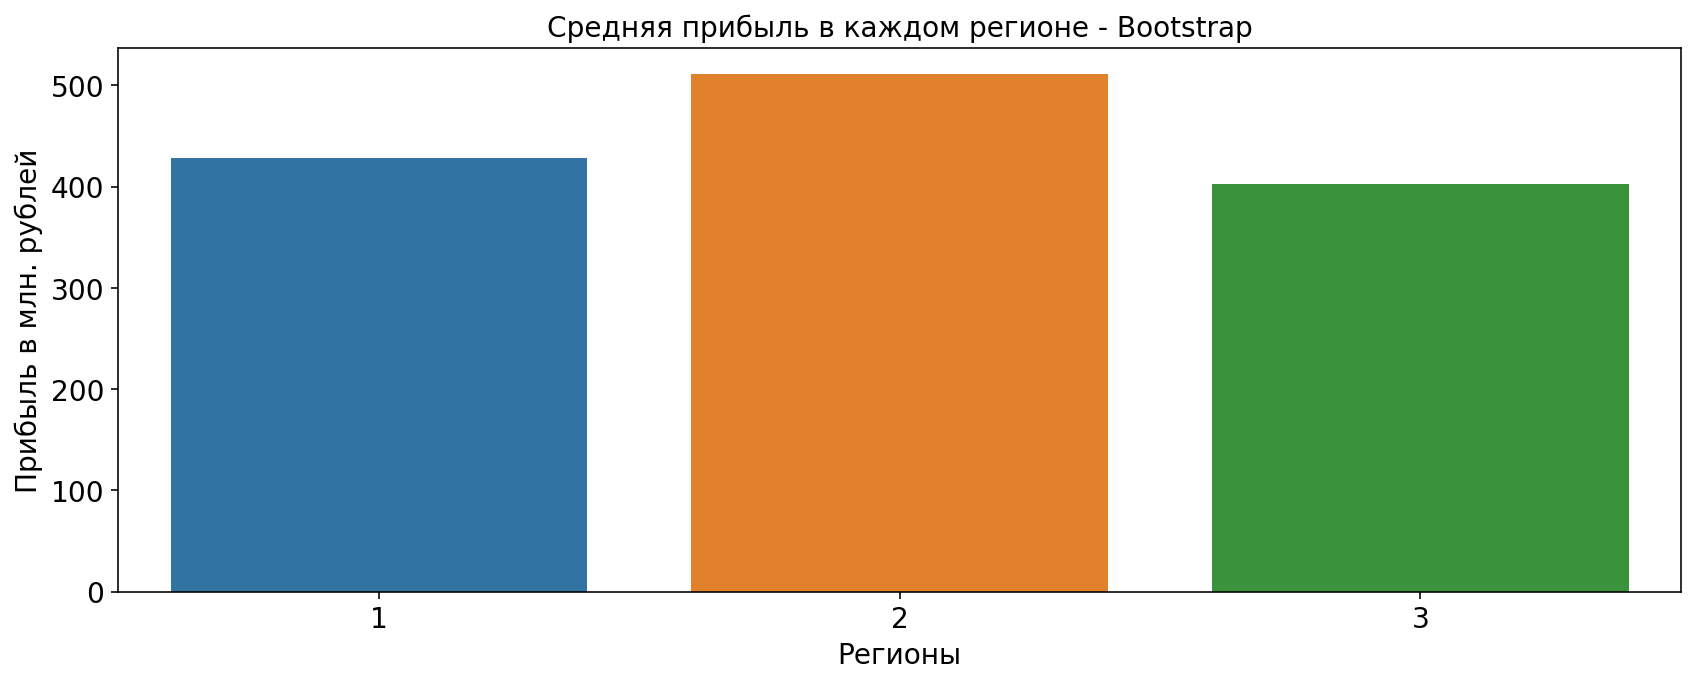

In [63]:
mean_regions_profit = pd.DataFrame({'regions':[1,2,3],'mean_profit': [region1_profit,region2_profit,region3_profit]})
display(mean_regions_profit)
drawPlot(mean_regions_profit,'regions','mean_profit','Регионы'
         ,'Прибыль в млн. рублей','Средняя прибыль в каждом регионе - Bootstrap','regions')

На таблице и на графике видно, что второй регион превосходит остальных по средней прибыли:
1. Средняя прибыль второго региона - **511.363 млн. рублей**
2. Средняя прибыль первого региона - **427.848 млн. рублей**
3. Средняя прибыль третьего региона - **402.576 млн. рублей**

<a id="confidenceInterval"></a>
## Доверительный интервал

В бизнесе важно понимать риски и оценивать, какое возможное значение может принимать нужная нам величина.

Необходимо посчитать **95%** доверительный интервал для каждого региона. Напишем функцию для расчёта.

In [64]:
def confidenceInterval(profits):
    """
    Функция для подсчёта доверительного интервала
    profits - прибыль
    """
    return (profits.quantile(0.025), profits.quantile(0.975))

### Регион 1

In [65]:
region1_ci = confidenceInterval(pd.Series(region1_profits))
print(f'Средняя прибыль в первом регионе: {region1_profit} млн. рублей')
print(f'95%-ый доверительный интервал: {round(region1_ci[0] / 1000000,3)} млн. - {round(region1_ci[1] / 1000000,3)} млн. рублей')

Средняя прибыль в первом регионе: 427.848 млн. рублей
95%-ый доверительный интервал: -97.25 млн. - 954.215 млн. рублей


Доверительный интервал первого региона - от **-97.25 млн.** до **954.215 млн. рублей**. Заметим, что в доверительном интервале есть *отрицательная прибыль* или же *чистый убыток*.

### Регион 2

In [66]:
region2_ci = confidenceInterval(pd.Series(region2_profits))
print(f'Средняя прибыль во втором регионе: {region2_profit} млн. рублей')
print(f'95%-ый доверительный интервал: {round(region2_ci[0] / 1000000,3)} млн. - {round(region2_ci[1] / 1000000,3)} млн. рублей')

Средняя прибыль во втором регионе: 511.363 млн. рублей
95%-ый доверительный интервал: 98.871 млн. - 940.721 млн. рублей


Доверительный интервал второго региона - от **98.871 млн.** до **940.721 млн. рублей**.

### Регион 3

In [67]:
region3_ci = confidenceInterval(pd.Series(region3_profits))
print(f'Средняя прибыль в третьем регионе: {region3_profit} млн. рублей')
print(f'95%-ый доверительный интервал: {round(region3_ci[0] / 1000000,3)} млн. - {round(region3_ci[1] / 1000000,3)} млн. рублей')

Средняя прибыль в третьем регионе: 402.576 млн. рублей
95%-ый доверительный интервал: -137.162 млн. - 929.888 млн. рублей


Доверительный интервал второго региона - от **-137.162 млн.** до **929.888 млн. рублей**. Заметим, что в доверительном интервале есть *отрицательная прибыль* или же *чистый убыток*.

В первом и в третьем регионе, в доверительном интервале есть *отрицательная прибыль* (*чистый убыток*). Тем временем, во втором регионе только чистая прибыль.

<a id="riskOfLosses"></a>
## Риск убытков

Напишем функцию для оценки риска убытков.

In [68]:
def riskOfLosses(profits):
    """
    Функция для оценки риска убытков
    profits - прибыль
    """
    # найдем места где есть убытки
    losses = profits < 0
    # считаем риск
    risk_of_losses = round((losses.sum() / len(profits)) * 100,3)
    # выводим риск
    print(f'Риск убытков - {risk_of_losses}%')
    return risk_of_losses

### Регион 1

In [69]:
region1_risk_of_losses = riskOfLosses(pd.Series(region1_profits))

Риск убытков - 5.5%


### Регион 2

In [70]:
region2_risk_of_losses = riskOfLosses(pd.Series(region2_profits))

Риск убытков - 0.9%


### Регион 3

In [71]:
region3_risk_of_losses = riskOfLosses(pd.Series(region3_profits))

Риск убытков - 7.4%


Создадим таблицу из полученных данных

regions  risk_of_loss
0        1         5.500
1        2         0.900
2        3         7.400

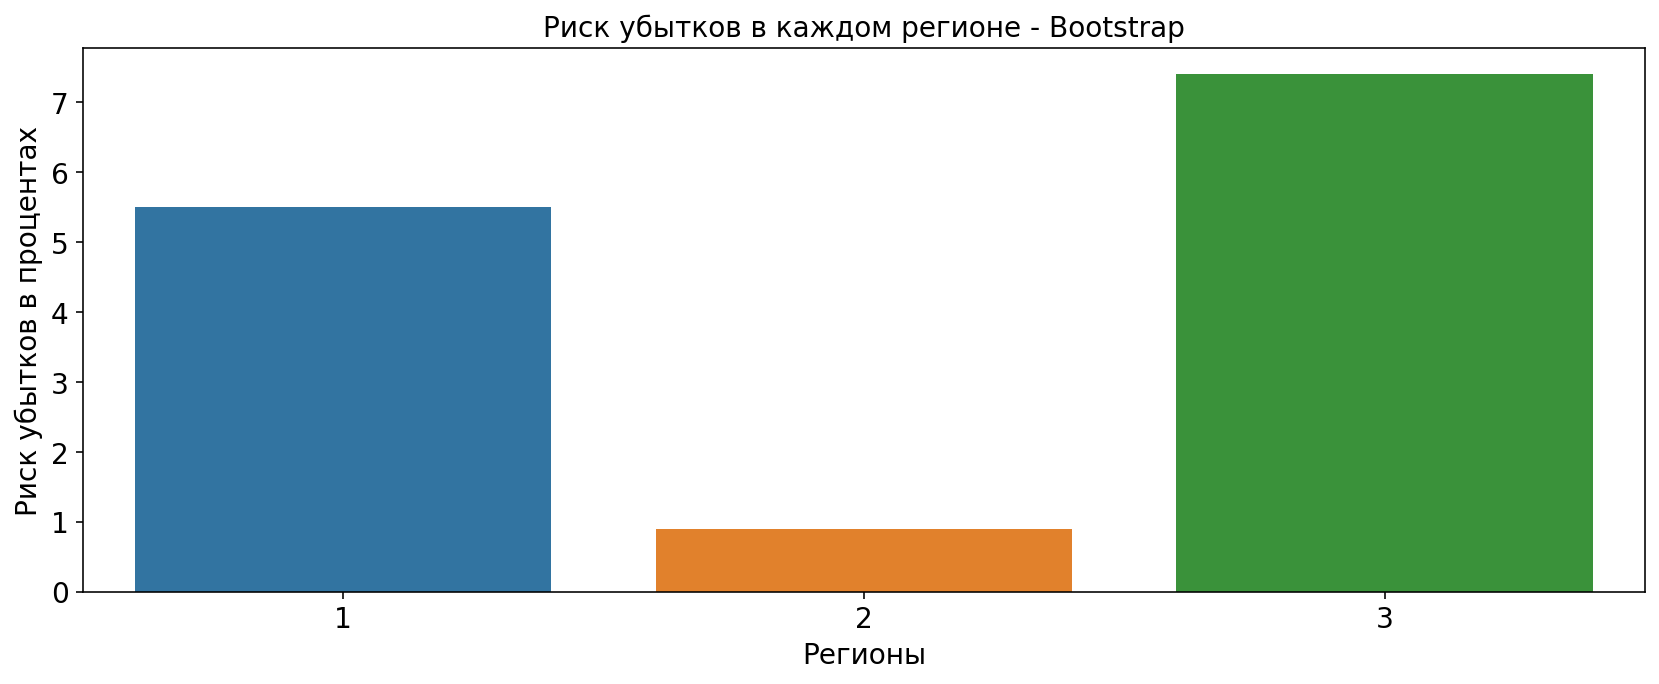

In [72]:
regions_risk_of_losses = pd.DataFrame({'regions':[1,2,3],'risk_of_loss':[region1_risk_of_losses,region2_risk_of_losses,region3_risk_of_losses]})
display(regions_risk_of_losses)
drawPlot(regions_risk_of_losses,'regions','risk_of_loss','Регионы'
         ,'Риск убытков в процентах','Риск убытков в каждом регионе - Bootstrap','regions')

Как видим, во втором регионе самый маленький риск убытков - **0.900**. В остальных регионах (первый и третий) есть существенный риск - **5.500** и **7.400** соответственно.

## Вывод

Основываясь на результатах:
1. Средняя прибыль в каждом регионе:
    - Второй регион превосходит остальных по средней прибыли. Средняя прибыль второго региона - **511.363 млн. рублей**. Средняя прибыль первого региона - **427.848 млн. рублей**.Средняя прибыль третьего региона - **402.576 млн. рублей**.
2. Доверительный интервал:
    - Доверительный интервал первого региона - от **-97.25 млн.** до **954.215 млн. рублей**.
    - Доверительный интервал второго региона - от **98.871 млн.** до **940.721 млн. рублей**.
    - Доверительный интервал второго региона - от **-137.162 млн.** до **929.888 млн. рублей**.
3. Риск убытков:
    - во втором регионе самый маленький риск убытков - **0.900%**. В остальных регионах (первый и третий) есть существенный риск - **5.500%** и **7.400%** соответственно.
    
Второй регион показал хорошие результаты на бизнес метриках. Следовательно, выберем его в качестве региона для разработки скважин.


<br>

<a id="results"></a>
# Этап 7 - Результаты работы

В ходе проекта мы успешно построили модель, которая помогла выбрать регион с наибольшей рентабельностью за счет прогнозирования объема запасов в новых скважинах. Определили регион для разработки скважин:
1. Обучили модели (*Линейной регрессии*) машинного обучения для каждого региона. Перебрали гиперпараметры, посмотрели значения метрик:
    - RMSE (квадратный корень из средней квадратичной ошибки). Модели из первого и третьего региона ошибаются на ~**40 тыс. баррелей**. Тем временем, модель из второго региона ошибается всего на ~**890 баррелей**.
    - Коэффициент детерминации, или метрика R2. втором регионе модель *Линейной регрессии* была точна в предсказаниях - **1.00**. Предполагаю точность модели во втором регионе как-то связана с коррелацией в признаках(*f2*,*products*) которые мы нашли на этапе обзора данных. В остальных регионах точность была около ~ от **0.2** до **0.3**.
    - MAE. Модели из третьего и первого региона ошибаются на **30 тыс. баррелей**. Тем временем, модель из второго всего **717 баррелей**.
    - Посчитали средний запас предсказанного сырья. У моделей из третьего региона разница (**229 баррелей**) между средними превоcходит в два раза чем у моделей из первого(**101 баррль**) и второго регионов(**112 баррелей**).
2. Посчитали сколько необходимо бюджета для разработки одной скважины. **50 миллинов рублей** нужно для разработки одной скважины. Рассчитали достаточный обьём сырья для безубыточной разработки новой скважины. Необходимо **111.111 тыс. баррелей** для безубыточной разработки новой скважины. Сравнили полученный обьём сырья со средним запасом в каждом регионе. Cредних запасов сырья в каждом регионе не хватает для безубыточной разработки. У нас есть убыточные скважины в каждом регионе. Следовательно, необходимо исследовать 500 точек, из которых с помощью машинного обучения выбирем 200 лучших для разработки.
3. Мы написали функцию для расчёта прибыли. Выяснили ,что без выборки 500 случайных точек, больше всего прибыли получилось в первом регионе ~**3.359 млрд. рублей**. Во втором и третьем - ~**2.415 млрд. рублей**, **2.599 млрд. рублей** соответственно.
4. Применили технику *Bootstrap* с 1000 выборок, что позволит найти распределение прибыли. Также, нашли среднюю прибыль, *95%* доверительный интервал, и риск убытков. Основываясь на результатах:
    1. Средняя прибыль в каждом регионе:
        - Второй регион превосходит остальных по средней прибыли. Средняя прибыль второго региона - **511.363 млн. рублей**. Средняя прибыль первого региона - **427.848 млн. рублей**.Средняя прибыль третьего региона - **402.576 млн. рублей**.
    2. Доверительный интервал:
        - Доверительный интервал первого региона - от **-97.25 млн.** до **954.215 млн. рублей**.
        - Доверительный интервал второго региона - от **98.871 млн.** до **940.721 млн. рублей**.
        - Доверительный интервал второго региона - от **-137.162 млн.** до **929.888 млн. рублей**.
    3. Риск убытков:
        - во втором регионе самый маленький риск убытков - **0.900%**. В остальных регионах (первый и третий) есть существенный риск - **5.500%** и **7.400%** соответственно.
    
**Второй регион** показал хорошие результаты на бизнес метриках. Следовательно, выберем его в качестве региона для разработки скважин.
